In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pylab import rcParams
rcParams['figure.figsize'] = 25, 16
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\정소연\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
traindf = pd.read_json('train.json')
testdf = pd.read_json('test.json')

In [33]:
traindf["cuisine"].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [34]:
traindf["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

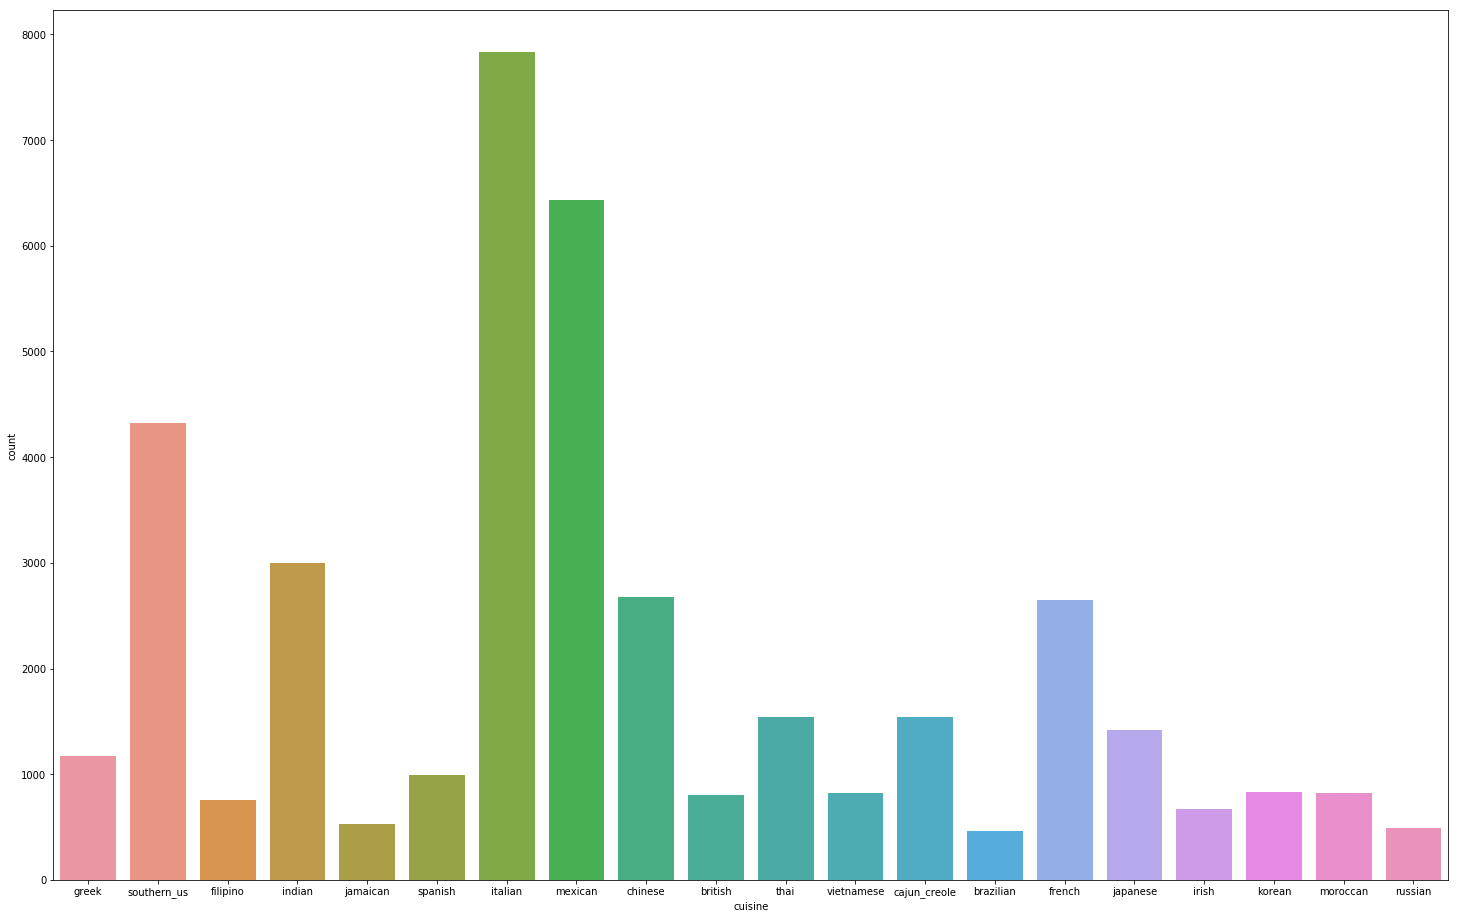

In [35]:
sns.countplot(x="cuisine", data=traindf)

In [36]:
traindf["len_ingredients"] = traindf["ingredients"].apply(lambda x: len(x))
testdf["len_ingredients"] = testdf["ingredients"].apply(lambda x: len(x))

In [37]:
traindf.sort_values(by=["len_ingredients"],ascending=False).head(5)

,cuisine,id,ingredients,len_ingredients
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65
30350,brazilian,13430,"[marshmallows, fresh corn, cheddar cheese, shr...",59
26103,mexican,13049,"[vanilla ice cream, lime, garlic powder, zucch...",52
10513,mexican,49282,"[condensed cream of chicken soup, pepper, refr...",49
22906,indian,2253,"[white vinegar, sparkling lemonade, coconut su...",49


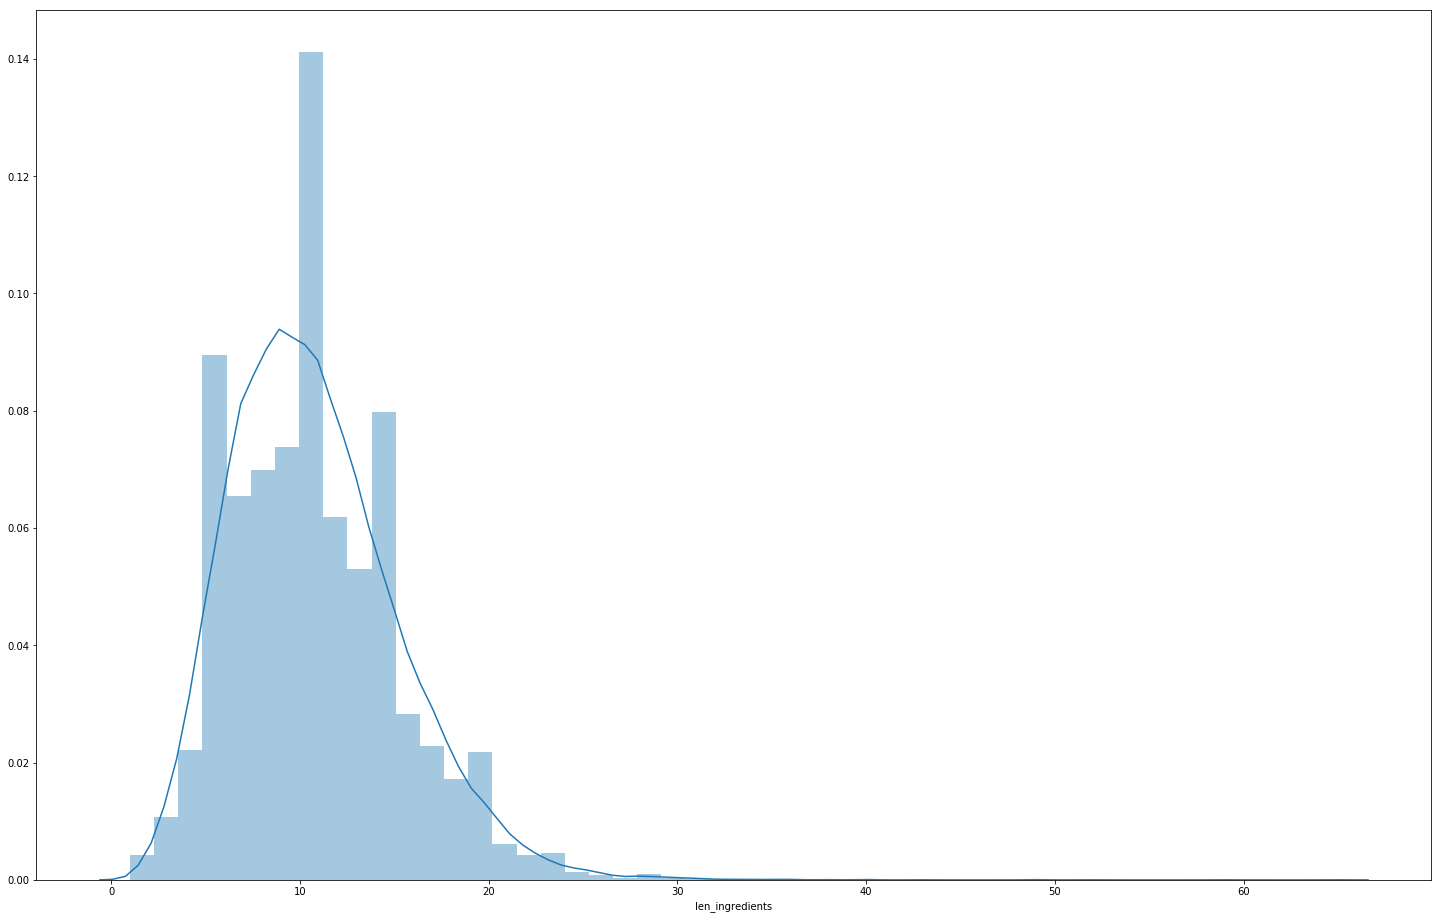

In [38]:
sns.distplot(traindf["len_ingredients"])

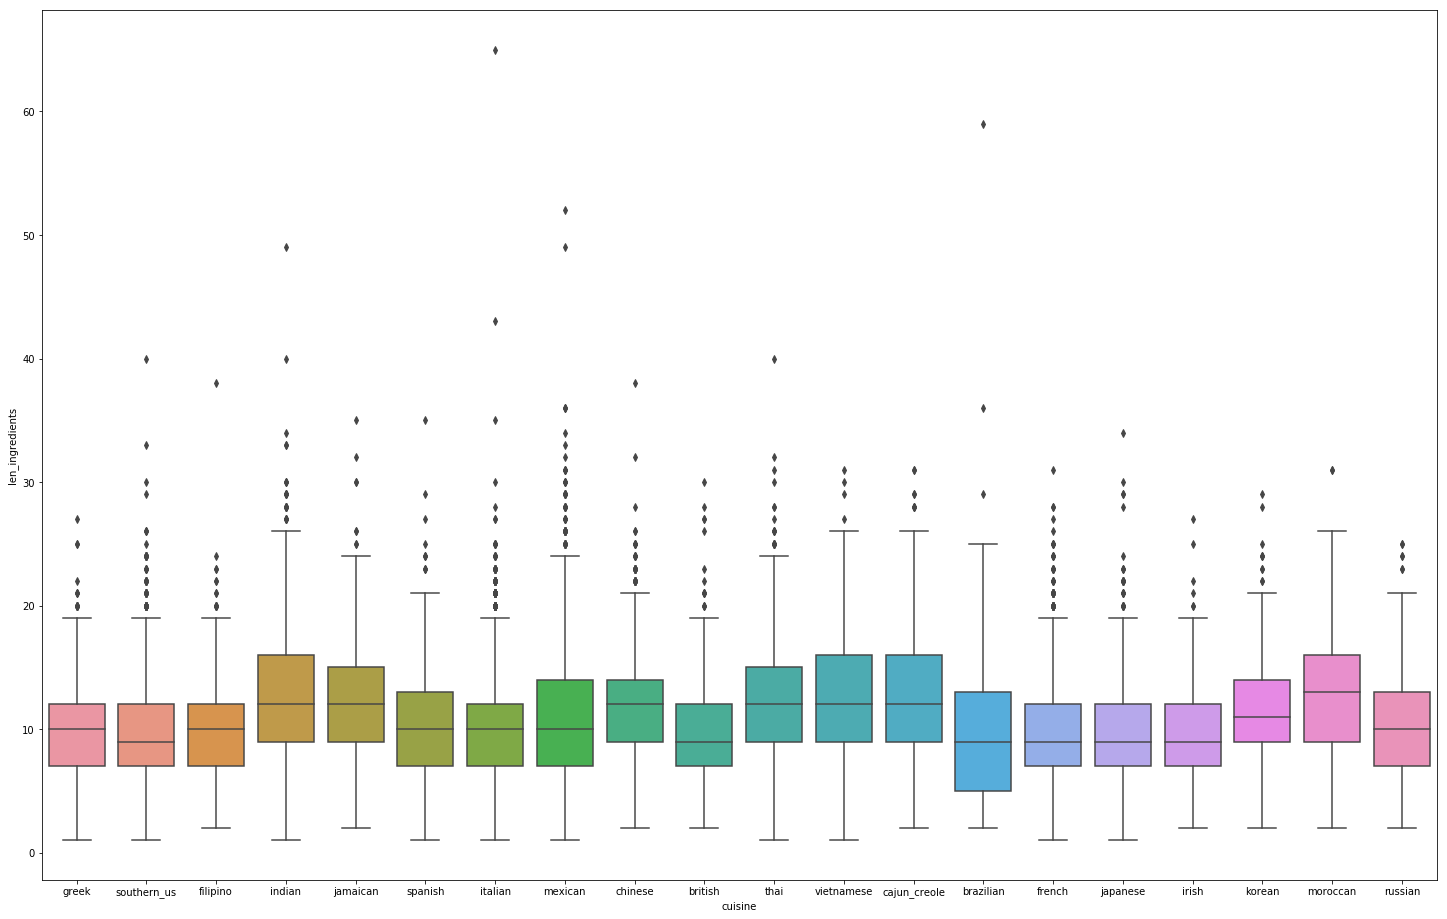

In [39]:
sns.boxplot(y="len_ingredients",x="cuisine", data=traindf)

In [40]:
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in traindf['ingredients']]       
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       

In [41]:
corpustr = traindf['ingredients_string']
estimators = [("tfidf", TfidfVectorizer(stop_words='english',
             ngram_range = ( 1 , 1 ),analyzer="word",
             max_df = .57 , binary=False ,max_features =6706, token_pattern=r'\w+' , sublinear_tf=False) ),
             ("hash", HashingVectorizer ( stop_words='english',
             ngram_range = ( 1 , 2 ),n_features  =6706,analyzer="word",token_pattern=r'\w+', binary =False))]

In [42]:
tfidftr = FeatureUnion(estimators).fit_transform(corpustr).todense()
corpusts = testdf['ingredients_string']
tfidfts = FeatureUnion(estimators).transform(corpusts)

In [43]:
predictors_tr = tfidftr
targets_tr = traindf['cuisine']
predictors_ts = tfidfts

In [44]:
classSVC = LinearSVC(C=0.3999, penalty="l2", dual=False) 
classSVC = classSVC.fit(predictors_tr,targets_tr)

In [45]:
predictions = classSVC.predict(predictors_ts) 
testdf['cuisine'] = predictions
testdf = testdf.sort_values('id' , ascending=True)

In [46]:
testdf[['id' , 'cuisine' ]].to_csv("pl.csv", index=False)